# Evaluation


In [1]:
import sys
import os
sys.path.append('../') #act as if we are one directory higher so imports work 
import torch
from latent_to_timestep_model import LTT_model
from dataset import load_data_from_dir
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from torch import nn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.express as px

In [2]:
path = "/netpool/homes/connor/DiffusionModels/LD3_connor/train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0"
latents, targets, conditions, unconditions = load_data_from_dir(data_folder=path, limit=200)
steps = 5


## LTT Model

In [23]:
model_path, steps = "/netpool/homes/connor/DiffusionModels/LD3_connor/logs/logs_cifar10/N10-val50-train450-rv12-seed0/final_ltt_model.pt", 10
model_path, steps = "/netpool/homes/connor/DiffusionModels/LD3_connor/logs/logs_cifar10/N10-val50-train50-rv12-seed0/ltt_model.pt", 10

model_path, steps = "/netpool/homes/connor/DiffusionModels/LD3_connor/logs/logs_cifar10/N10-val50-train450-rv12-seed0-fixed_scaling/final_ltt_model.pt", 10
model_path, steps  = "/netpool/homes/connor/DiffusionModels/LD3_connor/logs/logs_cifar10/N7-val50-train450-rv12-seed0-fixed_scaling/final_ltt_model.pt", 7
model_path, steps = "/netpool/homes/connor/DiffusionModels/LD3_connor/logs/logs_cifar10/N5-val50-train450-rv12-seed0-fixed_scaling/final_ltt_model.pt", 5
# model_path, steps = "/netpool/homes/connor/DiffusionModels/LD3_connor/logs/logs_cifar10/N3-val50-train450-rv12-seed0-fixed_scaling/final_ltt_model.pt", 3
model_path, steps = "/netpool/homes/connor/DiffusionModels/LD3_connor/logs/logs_cifar10/LTT_batch3_moreData_N5-val50-train450-r5/final_ltt_model.pt", 5


ltt_model = LTT_model(steps=steps)
state_dict = torch.load(model_path, weights_only=True)
ltt_model.load_state_dict(state_dict)  # Load the model state

<All keys matched successfully>

In [24]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(ltt_model))

19263606


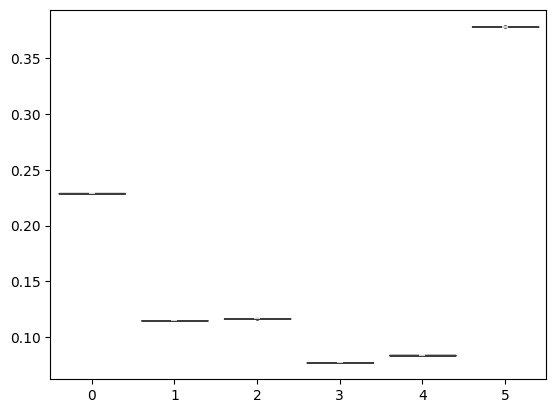

In [25]:

params_list = ltt_model.forward(torch.stack(latents)) 

#visualize as violin plot over each of the 10 timesteps
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

params_list = params_list.detach().numpy()
params_list = params_list.reshape(-1, steps+1)
params_list = pd.DataFrame(params_list, columns=[f"{i}" for i in range(steps+1)])
sns.violinplot(data=params_list)
plt.show()


In [26]:
params_list


,0,1,2,3,4,5
0,0.228996,0.114896,0.116618,0.077159,0.083689,0.378642
1,0.229003,0.114892,0.116614,0.077155,0.083684,0.378653
2,0.228990,0.114900,0.116621,0.077162,0.083693,0.378635
3,0.228987,0.114902,0.116623,0.077164,0.083695,0.378631
4,0.228986,0.114903,0.116623,0.077164,0.083696,0.378629
...,...,...,...,...,...,...
195,0.228992,0.114898,0.116620,0.077161,0.083691,0.378638
196,0.228986,0.114902,0.116623,0.077164,0.083695,0.378630
197,0.228991,0.114899,0.116620,0.077161,0.083692,0.378636
198,0.228979,0.114907,0.116627,0.077168,0.083700,0.378620


### U-net encoding

In [ ]:
# Create a dictionary to store the output
hook_storage = {}

# Define the hook function using a closure
def get_hook(storage):
    def hook_fn(module, input, output):
        storage["unet_output"] = output  # Store output in the dictionary
    return hook_fn
# Register the hook on the UNet
hook_handle = ltt_model.unet.register_forward_hook(get_hook(hook_storage))

# Run the forward pass
output = ltt_model.forward(latents[0])

# Retrieve the stored UNet output
unet_output = hook_storage["unet_output"]
print("Stored UNet Output:", unet_output.shape)




In [ ]:
def mse(tensor1, tensor2):
    return torch.mean((tensor1 - tensor2) ** 2)

In [ ]:
encodings = []
num_matrices = 20
for latent in latents[:num_matrices]:
    output = ltt_model.forward(latent)
    encodings.append(hook_storage["unet_output"])


mse_matrix = np.zeros((num_matrices, num_matrices))

for i in range(num_matrices):
    for j in range(num_matrices):
        mse_matrix[i, j] = mse(encodings[i], encodings[j])

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(mse_matrix, annot=False, cmap="viridis", linewidths=0.5)
plt.title("Pairwise MSE Heatmap")
plt.xlabel("Matrix Index")
plt.ylabel("Matrix Index")
plt.show()



In [ ]:
encodings[1]

In [ ]:
encodings[2]

## Optimal Timesteps

In [ ]:
#load from torch.save(loss_matrix, os.path.join(args.data_dir, f"loss_matrix.pt"))
data_dir = "/netpool/homes/connor/DiffusionModels/LD3_connor/train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0/"
loss_matrix = torch.load(os.path.join(data_dir, f"loss_matrix.pt"))

In [ ]:
loss_matrix

In [ ]:
#plot loss matrix

plt.figure(figsize=(10, 8))
sns.heatmap(loss_matrix, annot=False, cmap="viridis", linewidths=0.5)
plt.title("Pairwise MSE Heatmap")
plt.xlabel("Matrix Index")
plt.ylabel("Matrix Index")
plt.show()

In [ ]:
#find lowest loss matrix
min_loss = torch.min(loss_matrix, axis=1)
min_loss

In [ ]:
plt.figure(figsize=(10, 8))
for i in range(6):
    min_values = [torch.min(loss_matrix[i, :j+1,]).item() for j in range(300)]
    plt.plot(range(300), min_values, label=f'Line {i+1}')
plt.title("Lowest Value of Second Dimension Up to That Point")
plt.xlabel("Steps")
plt.ylabel("Lowest Value")
plt.legend()
plt.show()

In [ ]:
gradient_matrix = torch.load(os.path.join(data_dir, f"loss_grad_matrix.pt"))
gradient_matrix.shape

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(gradient_matrix[2], annot=False, cmap="viridis", linewidths=0.5)
plt.title("Pairwise MSE Heatmap")
plt.xlabel("Matrix Index")
plt.ylabel("Matrix Index")
plt.show()


In [ ]:
plt.figure(figsize=(10, 8))
for i in range(6):
    plt.plot(range(300), abs(gradient_matrix[2, :, i]), label=f'Line {i+1}')
plt.yscale('log')
plt.title("Gradient Matrix Lines")
plt.xlabel("Steps")
plt.ylabel("Gradient Value (log scale)")
plt.legend()
plt.show()


In [ ]:
test_tensor = torch.tensor([1,2,3,4,5,6], dtype=torch.float32)
test_tensor2 = torch.tensor([1,2,3,4,5,6], dtype=torch.float32)*2
test_tensor3 = torch.tensor([1,2,3,4,5,6], dtype=torch.float32)+1

m = nn.Softmax()
print(m(test_tensor))
print(m(test_tensor2))
print(m(test_tensor3))

### Compare optimal params for different images

In [ ]:
pt_files = [f for f in os.listdir(path) if "optimal_params" in f]
for i, file_name in enumerate(sorted(pt_files)[:]): #load all training files previously created
    file_path = os.path.join(path, file_name)
    params, loss = torch.load(file_path, weights_only=True)
    data = params.detach().numpy()
    losses = loss.detach().numpy()

    # Standardize the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # Apply PCA to reduce to 2 dimensions
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(data_scaled)

    # Plot the results
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(principal_components[:, 0], principal_components[:, 1],
                        c=losses, cmap='viridis', edgecolor='k', s=100)
    plt.colorbar(scatter, label='Loss')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA Visualization Colored by Loss')
    plt.grid(True)
    plt.show()
    print("params\n", data)
    print("losses\n", losses)
    if i > 5:
        break

In [ ]:
pt_files = [f for f in os.listdir(path) if "optimal_params" in f]
pt_files = sorted(pt_files)[:6]  # Load first 6 training files

shapes = ['circle', 'square', 'diamond', 'triangle-up', 'triangle-down', 'cross']  # Different marker shapes

all_data = []
best_losses = []



for i, file_name in enumerate(pt_files):
    file_path = os.path.join(path, file_name)
    # Load parameters and loss
    params, loss = torch.load(file_path, weights_only=True)  
    data = params.detach().numpy()
    losses = loss.detach().numpy()
    all_data.append(data)
    best_losses.append(losses)





all_data = np.stack(all_data).reshape(-1, steps+1)
best_losses = np.stack(best_losses).reshape(-1)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(all_data)
    
# Convert to DataFrame
df = pd.DataFrame(principal_components, columns=["PC1", "PC2"])
df["Loss"] = best_losses
df["Shape"] = [x for x in shapes for _ in range(10)]
df["params"] = list(all_data)
df["params"] = df["params"].apply(lambda x: [round(v, 4) for v in x])

# # Create interactive 3D scatter plot using Plotly
fig = px.scatter(df, x="PC1", y="PC2", color="Loss", symbol="Shape",
                    hover_data={"Loss": ":.4f", "PC1": False, "PC2": False, "params": True},
                    color_continuous_scale="viridis",
                    title="2D PCA Visualization Colored by Loss with Different Shapes")

# Move color bar to the left
fig.update_layout(coloraxis_colorbar=dict(x=-0.2))  

fig.update_traces(marker=dict(size=5, line=dict(width=1, color="black")))

# Show interactive 3D plot
fig.show() 

In [ ]:
pt_files = [f for f in os.listdir(path) if "optimal_params" in f]
pt_files = sorted(pt_files)[:6]  # Load first 6 training files

shapes = ['circle', 'square', 'diamond', 'triangle-up', 'triangle-down', 'cross']  # Different marker shapes

all_data = []
best_losses = []



for i, file_name in enumerate(pt_files):
    file_path = os.path.join(path, file_name)
    # Load parameters and loss
    params, loss = torch.load(file_path, weights_only=True)  
    data = params.detach().numpy()
    losses = loss.detach().numpy()
    all_data.append(data)
    best_losses.append(losses)


all_data = np.stack(all_data).reshape(-1, steps+1)
best_losses = np.stack(best_losses).reshape(-1)

pca = PCA(n_components=3)
principal_components = pca.fit_transform(all_data)
    
# Convert to DataFrame
df = pd.DataFrame(principal_components, columns=["PC1", "PC2", "PC3"])
df["Loss"] = best_losses
df["Shape"] = [x for x in shapes for _ in range(10)]
df["params"] = list(all_data)
df["params"] = df["params"].apply(lambda x: [round(v, 4) for v in x])

# # Create interactive 3D scatter plot using Plotly
fig = px.scatter_3d(df, x="PC1", y="PC2", z="PC3", color="Loss", symbol="Shape",
                    hover_data={"Loss": ":.4f", "PC1": False, "PC2": False, "PC3": False, "params": True},
                    color_continuous_scale="viridis",
                    title="3D PCA Visualization Colored by Loss with Different Shapes")

# Move color bar to the left
fig.update_layout(coloraxis_colorbar=dict(x=-0.2))  

fig.update_traces(marker=dict(size=5, line=dict(width=1, color="black")))

# Show interactive 3D plot
fig.show() 

In [ ]:
plt.figure(figsize=(10, 8))
sns.histplot(best_losses, bins=50, kde=True)
plt.title("Loss Distribution")
plt.xlabel("Loss")
plt.ylabel("Frequency")
plt.show()


#### Only best trial

In [ ]:
pt_files = [f for f in os.listdir(path) if "optimal_params" in f]
pt_files = sorted(pt_files) # Load first 6 training files

all_data = []
best_losses = []
all_losses = []

for i, file_name in enumerate(pt_files):
    file_path = os.path.join(path, file_name)
    # Load parameters and loss
    params, loss = torch.load(file_path, weights_only=True)  
    data = params.detach().numpy()[0]
    losses = loss.detach().numpy()
    all_data.append(data)
    best_losses.append(losses[0])
    all_losses.append(losses)






all_data = np.stack(all_data).reshape(-1, steps+1)
best_losses = np.stack(best_losses).reshape(-1)

pca = PCA(n_components=3)
principal_components = pca.fit_transform(all_data)
    
# Convert to DataFrame
df = pd.DataFrame(principal_components, columns=["PC1", "PC2", "PC3"])
df["Loss"] = best_losses
df["params"] = list(all_data)
df["params"] = df["params"].apply(lambda x: [round(v, 4) for v in x])

# # Create interactive 3D scatter plot using Plotly
fig = px.scatter_3d(df, x="PC1", y="PC2", z="PC3", color="Loss",
                    hover_data={"Loss": ":.4f", "PC1": False, "PC2": False, "PC3": False, "params": True},
                    color_continuous_scale="viridis",
                    title="3D PCA Visualization Colored by Loss with Different Shapes")

# Move color bar to the left
fig.update_layout(coloraxis_colorbar=dict(x=-0.2))  

fig.update_traces(marker=dict(size=5, line=dict(width=1, color="black")))

# Show interactive 3D plot
fig.show()

In [ ]:
#plot loss distribution of all_losses

plt.figure(figsize=(10, 8))
sns.histplot(best_losses, bins=50, kde=True)
plt.title("Loss Distribution")
plt.xlabel("Loss")
plt.ylabel("Frequency")
plt.show()



In [ ]:
import plotly.graph_objects as go

# Assuming all_losses and best_losses are defined
all_losses = np.stack(all_losses).reshape(-1)

fig = go.Figure()

# Add histogram for all_losses
fig.add_trace(go.Histogram(x=all_losses, nbinsx=75, histnorm='probability density', 
                           name="All Losses", marker_color='blue', opacity=0.5))

# Add histogram for best_losses
fig.add_trace(go.Histogram(x=best_losses, nbinsx=75, histnorm='probability density', 
                           name="Best Losses", marker_color='red', opacity=0.5))

# Update layout
fig.update_layout(
    title="Loss Distribution",
    xaxis_title="Loss",
    yaxis_title="Density",
    barmode='overlay',  # Overlay both histograms
    template="plotly_white"  # Optional: use a clean background
)

fig.show()
print(f"Mean lost of first 50 validation losses: {np.mean(all_losses[:500]):.4f}")
print(f"Mean lost of 50 validation best losses: {np.mean(best_losses[:50]):.4f}")